In [1]:
# 1. Install YOLO
%pip install ultralytics
import ultralytics
from ultralytics import YOLO
import os, json, random, shutil
from pathlib import Path

# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
ultralytics.checks()

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.7/112.6 GB disk)


In [2]:
# Paths - Adjust if your folder name is different
base_dir = Path('/content/drive/MyDrive/vision')
img_src = base_dir / 'images'
lbl_src = base_dir / 'labels' # Ensure you renamed your labels folder to 'labels'

# Define the perfect YOLO structure
split_dir = Path('/content/training_data') # We build this on the local machine for speed
for s in ['train', 'val', 'test']:
    (split_dir / 'images' / s).mkdir(parents=True, exist_ok=True)
    (split_dir / 'labels' / s).mkdir(parents=True, exist_ok=True)

# Get all valid image-label pairs
all_images = [f for f in os.listdir(img_src) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
valid_pairs = []

for img_name in all_images:
    lbl_name = Path(img_name).stem + '.txt'
    if (lbl_src / lbl_name).exists():
        valid_pairs.append((img_name, lbl_name))

# Shuffle and Split (70% Train, 20% Val, 10% Test)
random.seed(42)
random.shuffle(valid_pairs)
n = len(valid_pairs)
train_end = int(n * 0.7)
val_end = int(n * 0.9)

splits = {'train': valid_pairs[:train_end], 'val': valid_pairs[train_end:val_end], 'test': valid_pairs[val_end:]}

# Copy files
for s_name, pairs in splits.items():
    print(f"Organizing {s_name} set ({len(pairs)} files)...")
    for img, lbl in pairs:
        shutil.copy(img_src / img, split_dir / 'images' / s_name / img)
        shutil.copy(lbl_src / lbl, split_dir / 'labels' / s_name / lbl)

print("✅ Perfect Data Split Complete!")

Organizing train set (434 files)...
Organizing val set (124 files)...
Organizing test set (62 files)...
✅ Perfect Data Split Complete!


In [3]:
yaml_content = f"""
path: /content/training_data
train: images/train
val: images/val
test: images/test

nc: 3
names: ['Back', 'Front', 'Side']
"""

with open('/content/2b_viewing_angle.yaml', 'w') as f:
    f.write(yaml_content)

print("✅ Config file '2b_viewing_angle.yaml' created!")

✅ Config file '2b_viewing_angle.yaml' created!


In [7]:
from ultralytics import YOLO

# 1. Load the model
model = YOLO('yolov8s.pt')

# 2. Start training
# This creates the '2B_Final_Test' folder that your plotter is looking for
results = model.train(
    data='/content/2b_viewing_angle.yaml',
    epochs=50,        # Start with 5 to make sure it works
    imgsz=640,
    batch=16,
    name='2B_Final_Test', # This MUST match the name in your plotter
    plots=True
)

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/2b_viewing_angle.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=2B_Final_Test2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

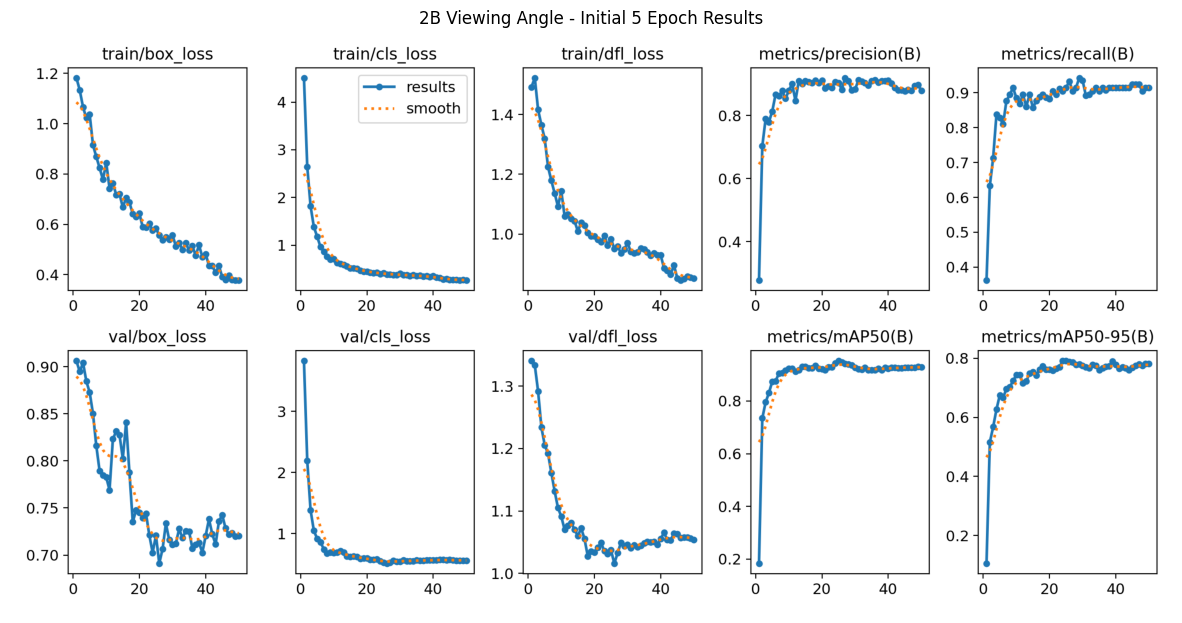

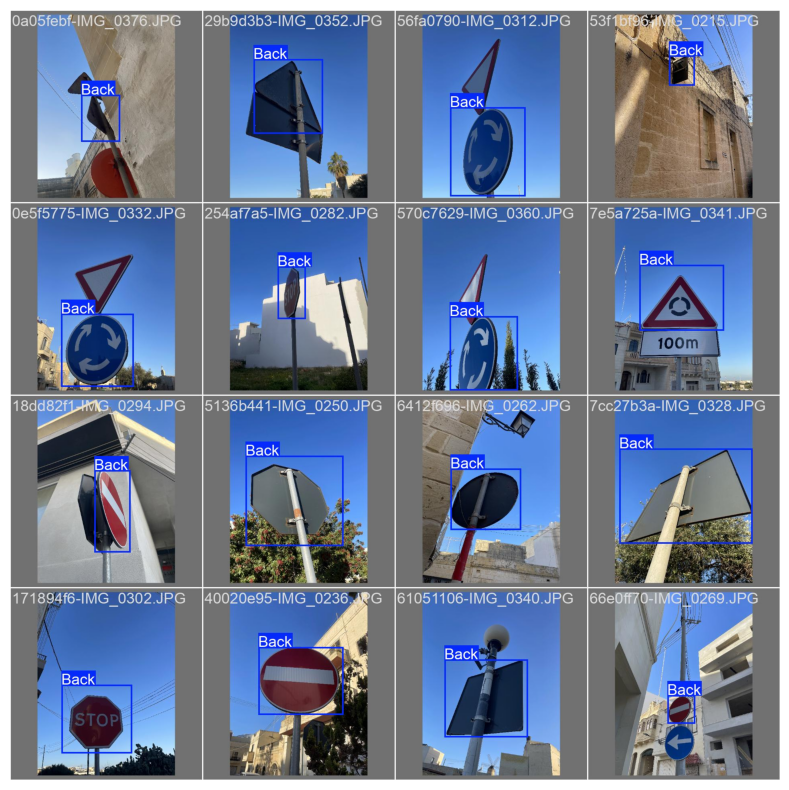

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show the results chart
res_path = '/content/runs/detect/2B_Final_Test2/results.png'
if os.path.exists(res_path):
    plt.figure(figsize=(15, 10))
    plt.imshow(mpimg.imread(res_path))
    plt.axis('off')
    plt.title("2B Viewing Angle - Initial 5 Epoch Results")
    plt.show()

# Show a sample of predictions
pred_path = '/content/runs/detect/2B_Final_Test2/val_batch0_labels.jpg'
if os.path.exists(pred_path):
    plt.figure(figsize=(15, 10))
    plt.imshow(mpimg.imread(pred_path))
    plt.axis('off')
    plt.show()

In [13]:
# --- Calculate Detailed Accuracy for 2B ---
import numpy as np
import pandas as pd

# Load the final validation results
# This looks at the BEST weights saved during your 50-epoch run
best_model = YOLO('/content/runs/detect/2B_Final_Test2/weights/best.pt')
metrics = best_model.val()

# Extract Class-wise Precision and Recall
# Precision: Quality of the positive prediction ("Of those called Front, how many were?")
# Recall: Ability to find the class ("Of all Front signs, how many did we find?")
class_names = ['Back', 'Front', 'Side']
precision = metrics.results_dict['metrics/precision(B)']
recall = metrics.results_dict['metrics/recall(B)']
mAP50 = metrics.results_dict['metrics/mAP50(B)']

# Create a clean summary table for your report
df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'mAP@50'],
    'Value': [f"{precision:.2%}", f"{recall:.2%}", f"{mAP50:.2%}"]
})

print("--- TASK 2B: VIEWING ANGLE PERFORMANCE ---")
print(df.to_string(index=False))

# Logic for "Critical Evaluation" in your report:
# If Recall is low for 'Side', say: "The model struggled with 'Side' views
# because they present a narrower profile with fewer distinctive features."

Ultralytics 8.4.6 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2563.9±2307.7 MB/s, size: 1154.1 KB)
val: Scanning /content/training_data/labels/val.cache... 96 images, 0 backgrounds, 28 corrupt: 100% ━━━━━━━━━━━━ 124/124 47.3Mit/s 0.0s
val: /content/training_data/images/val/05b54538-IMG_0061.jpg: ignoring corrupt image/label: cannot identify image file '/content/training_data/images/val/05b54538-IMG_0061.jpg'
val: /content/training_data/images/val/0bad10eb-IMG_0067.jpg: ignoring corrupt image/label: cannot identify image file '/content/training_data/images/val/0bad10eb-IMG_0067.jpg'
val: /content/training_data/images/val/2336f74e-IMG_0078.jpg: ignoring corrupt image/label: cannot identify image file '/content/training_data/images/val/2336f74e-IMG_0078.jpg'
val: /content/training_data/images/val/289c8b20-IMG_0227.jpg: ignoring corrupt imag